In [5]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [6]:
dataset_PT = TSD(file_path='../datasets/power_transitions.xlsx')

Dataset loaded from ../datasets/power_transitions.xlsx


In [7]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]

pt_dat = dataset_PT.raw[['PolityID', 'PolityName','Year']+crisis_vars].copy()


In [8]:
dt = 25
dataset = TSD(file_path=f'../datasets/{dt}_yr_dataset.xlsx')
dataset.scv_imputed = pd.DataFrame([])
dataset.scv['Hierarchy_sq'] = dataset.scv['Hierarchy']**2
# impute scale and non scale variables separately
scale_cols = ['Pop','Terr','Cap','Hierarchy', 'Hierarchy_sq']
dataset.impute_missing_values(scale_cols, use_duplicates = False)
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(non_scale_cols, use_duplicates = False)

Dataset loaded from ../datasets/25_yr_dataset.xlsx
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best o

KeyboardInterrupt: 

In [5]:
scale_cols = ['Pop','Terr','Cap']
dataset.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
# rescale the PCA according to variable Pop


# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

dataset.scv_imputed['Comp'] = (dataset.scv_imputed['Government']*11 + dataset.scv_imputed['Infrastructure']*12 + dataset.scv_imputed['Information']*13 + dataset.scv_imputed['Money']*6)/(11+13+12+6)

miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}

dataset.scv['Miltech'] = dataset.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)
dataset.scv_imputed['Miltech'] = dataset.scv['Miltech']
dataset.scv['Miltech'] = dataset.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)
dataset.scv_imputed['Miltech'] = dataset.scv['Miltech']

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 90.19%
PC2: 7.07%
PC3: 2.75%


In [6]:

for col in crisis_vars:
    dataset.scv_imputed[col] = np.nan
for i, row in dataset.scv_imputed.iterrows():
    # find entries in pt dataset that match the country and year
    match = pt_dat[(pt_dat['PolityID'] == row['PolityID']) & (pt_dat['Year'] >= row['Year'])& (pt_dat['Year'] < row['Year']+dt)]
    if len(match) == 0:
        continue
    for col in crisis_vars:
        if match[col].dropna().sum() > 0:
            dataset.scv_imputed.at[i, col] = match[col].dropna().sum()
            

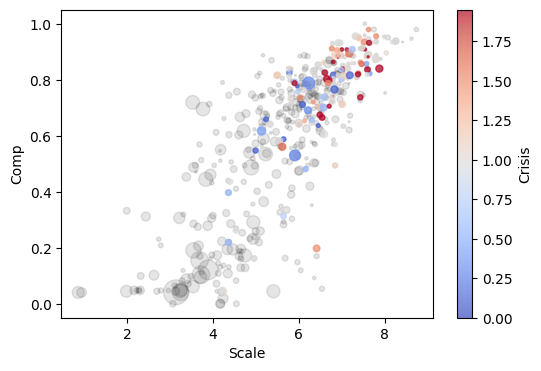

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset.scv_imputed[pd.isna(dataset.scv_imputed['predecessor_assassination'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['Comp'].mean()
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 2,
                      alpha=0.1,
                      )

dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
polity_group = dataset.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

In [8]:
dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
import statsmodels.api as sm
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp']
y_col = 'predecessor_assassination'
Xy = dataset_plot
Xy = Xy[[y_col]+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     predecessor_assassination   R-squared:                       0.082
Model:                                   OLS   Adj. R-squared:                  0.076
Method:                        Least Squares   F-statistic:                     14.26
Date:                       Mon, 24 Feb 2025   Prob (F-statistic):           1.16e-06
Time:                               12:57:16   Log-Likelihood:                -409.99
No. Observations:                        323   AIC:                             826.0
Df Residuals:                            320   BIC:                             837.3
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.3673      0.084      4.398      0.000       0.203       0.532
Comp          -0.3581      0.422     -0.848      0.397      -1.189       0.473
intercept     -1.1266      0.409     -2.756      0.006      -1.931      -0.322
==============================================================================
Omnibus:                      147.598   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              827.078
Skew:                           1.841   Prob(JB):                    2.53e-180
Kurtosis:                       9.921   Cond. No.                         64.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

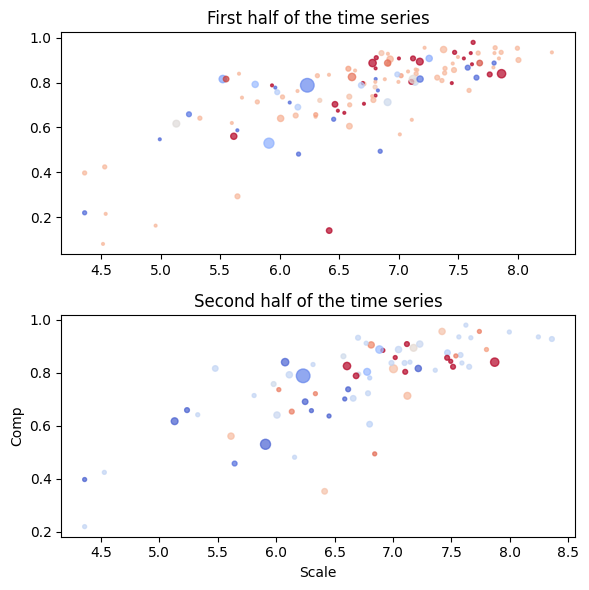

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(6, 6))

dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
polity_group = dataset_plot.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
mean_scale_1 = polity_group['Scale_1'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
mean_crisis = polity_group['predecessor_assassination'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = ax[0].scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )
ax[0].set_title('First half of the time series')
# Add a color bar
# ax[0].colorbar(scatter, label='Crisis')
# add name of polity on each bubble
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
mean_scale_1 = polity_group['Scale_1'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
mean_crisis = polity_group['predecessor_assassination'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
ax[1].set_title('Second half of the time series')
# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.tight_layout()
plt.show()

# Dynamic Regression

In [1]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['Comp_t'] = np.nan

dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = -group['Scale_1'] + group['Scale_1'].shift(-1)
    dr.loc[group.index, 'Comp_t'] = -group['Comp'] + group['Comp'].shift(-1)
    # remove rows without a value 100 yrs later
    mask = (group['Year'] - group['Year'].shift(-1) != -dt)
    indices = group.index.intersection(mask[mask].index)
    dr.loc[indices,'Scale_t'] = np.nan

NameError: name 'dataset' is not defined

In [2]:
x_cols = ['Scale_1','Comp','Miltech']
y_col = ['Scale_t']
Xy = dr
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols + ['intercept']]
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()


NameError: name 'dr' is not defined

NameError: name 'dr' is not defined

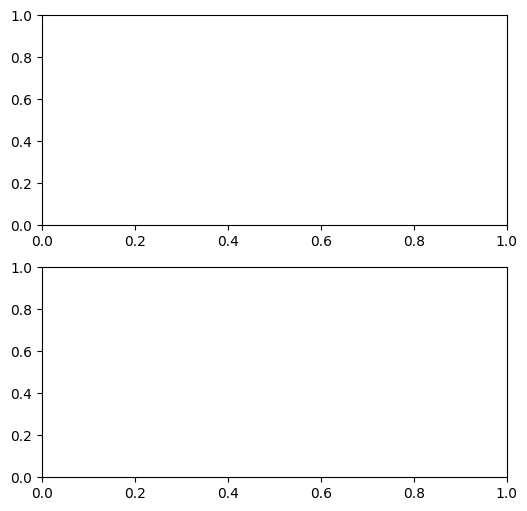

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(6, 6))

dataset_plot = dr.dropna(subset = ['Comp', 'Scale_1', 'Scale_t', 'Comp_t'])
polity_group = dataset_plot.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Scale_t'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.05
# Create a scatter plot
scatter = ax[0].scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )
ax[0].set_title('First half of the time series')
cbar = plt.colorbar(scatter, ax=ax[0])

# Add a color bar
# ax[0].colorbar(scatter, label='Crisis')
# add name of polity on each bubble
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Comp_t'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.05
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
ax[1].set_title('Second half of the time series')
# add colorbar to ax[1]
cbar = plt.colorbar(scatter, ax=ax[1])

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.tight_layout()
plt.show()

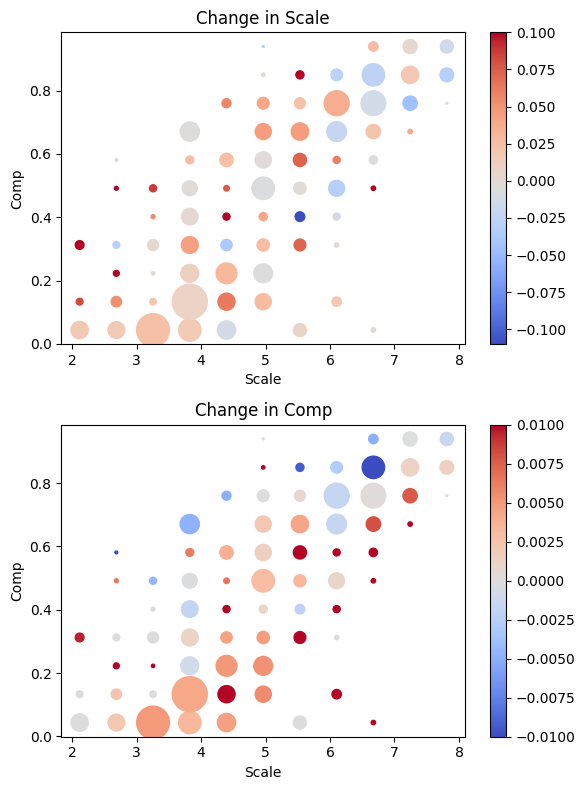

In [22]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['Scale_t','Comp_t']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["Scale_t"].values
z2 = Xy["Comp_t"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# # remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.1, vmin = 0.1)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.01, vmin = -0.01)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

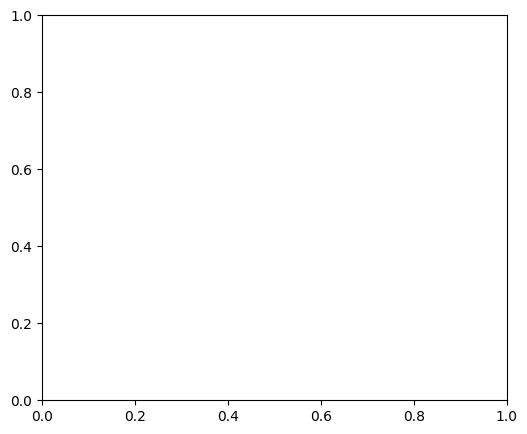

In [ ]:
# create vector plot
fig, ax = plt.subplots(figsize=(6, 5))

u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA
print(color.reshape(-1, 4).shape)
ax.quiver(x, y, u, v, scale=0.2, scale_units='xy', angles='xy', color=color.reshape(-1, 4), alpha=0.8)
ax.set_xlim(1, 9)
ax.set_ylim(0,1.1)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.show()